# Modelling with CNN

In [1]:
import numpy as np
import tensorflow as tf
import random as python_random

In [2]:
np.random.seed(1)
python_random.seed(12)
tf.random.set_seed(123)

In [3]:
# importing useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import re

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Loading in our selected top varieties data 

In [4]:
top_varieties_count = pd.read_csv('../input/wine-review-data-top-varieties/top_varieties_count.csv')
top_40_varieties = pd.read_csv('../input/wine-review-data-top-varieties/top_40_varieties.csv')
top_40_varieties.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,not_vintage,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Italy Vulkà Bianco Sicily & Sardinia Etna Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Portugal Avidagos Douro Quinta dos Avidagos,2011.0


### We know that in our dataset, *'United States of America'* is abrreviated as *'US'* and this will make our model to find it difficult to differentiate between the word *'us'* as a first person plural and as a country (after converting to lower case). We will solve this issue by replacing every occurence of *'US'* in ````country```` and ````not_vintage```` with *'United States of America'*.

In [5]:
top_40_varieties[top_40_varieties['country'] == 'US'].head(2) # a view of wine review data of US

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,not_vintage,vintage
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,US Oregon Willamette Valley Willamette Valley ...,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,US Reserve Late Harvest Michigan Lake Michigan...,2013.0


In [6]:
top_40_varieties['not_vintage'].apply(lambda x: 'US' in x).sum() # checks the number of rows with US

50734

In [7]:
# replacing every occurence of 'US' in country with 'United States of America'
top_40_varieties['country'].replace('US', 'United States of America', inplace=True)

# replacing every occurence of 'US' in not_vintage with 'United States of America'
top_40_varieties['not_vintage'] = top_40_varieties['not_vintage'].apply(lambda x: x.replace(\
                                                                        'US', 'United States of America'))

In [8]:
top_40_varieties[top_40_varieties['country'] == 'United States of America'].head(2) # a view of the dataset

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,not_vintage,vintage
2,United States of America,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,United States of America Oregon Willamette Val...,2013.0
3,United States of America,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,United States of America Reserve Late Harvest ...,2013.0


In [9]:
# asserting that there is no occurence of 'US' in country and not_vintage
assert 'US' not in top_40_varieties['country']
assert top_40_varieties['not_vintage'].apply(lambda x: 'US' in x).sum() == 0  

In [10]:
# renaming the columns in top_varieties_count
top_varieties_count = top_varieties_count.rename(columns={'variety': 'count', 'Unnamed: 0': 'variety'})
top_varieties_count = top_varieties_count.set_index('variety') # setting the index
top_varieties_count = top_varieties_count['count'] # making it a Series
top_varieties_count

variety
Pinot Noir                       13272
Chardonnay                       11753
Cabernet Sauvignon                9472
Red Blend                         8946
Bordeaux-style Red Blend          6915
Riesling                          5189
Sauvignon Blanc                   4967
Syrah                             4142
Rosé                              3564
Merlot                            3102
Nebbiolo                          2804
Zinfandel                         2714
Sangiovese                        2707
Malbec                            2652
Portuguese Red                    2466
White Blend                       2360
Sparkling Blend                   2153
Tempranillo                       1810
Rhône-style Red Blend             1471
Pinot Gris                        1455
Champagne Blend                   1396
Cabernet Franc                    1353
Grüner Veltliner                  1345
Portuguese White                  1159
Bordeaux-style White Blend        1066
Pinot Grigio     

In [11]:
top = 20 # selecting top 20 varities as our working varieties. note 1 < n <= 40

# making a datframe of our selecting top n varieties
top_df = top_40_varieties[top_40_varieties['variety'].isin(top_varieties_count.iloc[:top].index)]
print('percentage of initial 130k dataframe is {}%'.format(72))
print(len(top_df['variety'].unique()))
top_df.head(2)

percentage of initial 130k dataframe is 72%
20


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,not_vintage,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Italy Vulkà Bianco Sicily & Sardinia Etna Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Portugal Avidagos Douro Quinta dos Avidagos,2011.0


In [12]:
# threshold of miniority variety to over sample (use sentences as document instead of the whole description)
minority_threshold = 5000 

# making a dataframe of the miniority classes
minority_df = top_df[top_df['variety'].isin(top_varieties_count[top_varieties_count < \
                                                                      minority_threshold].index)]
print(minority_df.shape)
print(len(minority_df['variety'].unique()))
minority_df.head(2)

(38367, 15)
14


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,not_vintage,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Italy Vulkà Bianco Sicily & Sardinia Etna Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Portugal Avidagos Douro Quinta dos Avidagos,2011.0


### nltk and spacy are the two most popular libraries in NLP. We will just use nltk to tokenize sentences in our miniority class but for our heavy weight preprocessing, we will use spacy because it is mostly used in industries and has wealth of functionalities.

In [13]:
from nltk.tokenize import sent_tokenize # importing useful library

In [14]:
oversampled_miniority_lst = [] # empty list to store sentences as tokens miniority corpus

# creating a function to use sentences as tokens for the miniority classes
def over_sample_miniority(row):
    doc_list = sent_tokenize(row['description'])
    for sent in doc_list:
        row['description'] = sent
        oversampled_miniority_lst.append(list(row))

In [15]:
minority_df.apply(over_sample_miniority, axis=1); # over sample the miniority classes

In [16]:
# converts oversampled_miniority_lst to a dataframe
oversampled_miniority_df = pd.DataFrame(oversampled_miniority_lst, columns=minority_df.columns)
print(oversampled_miniority_df.shape)
oversampled_miniority_df.head(2)

(104101, 15)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,not_vintage,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Italy Vulkà Bianco Sicily & Sardinia Etna Nicosia,2013.0
1,Italy,"The palate isn't overly expressive, offering u...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Italy Vulkà Bianco Sicily & Sardinia Etna Nicosia,2013.0


In [17]:
# a view at the new descriptions of the oversampled miniority classes
oversampled_miniority_df['description'][:5].values

array(['Aromas include tropical fruit, broom, brimstone and dried herb.',
       "The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",
       'This is ripe and fruity, a wine that is smooth while still structured.',
       'Firm tannins are filled out with juicy red berry fruits and freshened with acidity.',
       "It's  already drinkable, although it will certainly be better from 2016."],
      dtype=object)

### we see that sentences are counted as tokens instead of the whole review

In [18]:
# selecting majority classes as a dataframe to concatenate to oversampled_miniority_lst
majority_df = top_df[top_df['variety'].isin(\
                                        top_varieties_count[top_varieties_count >= minority_threshold].index)]

# concatenates majority_df to oversampled_miniority_lst
balanced_df = pd.concat([majority_df, oversampled_miniority_df]) 
balanced_df = balanced_df.reset_index().drop('index', axis=1) # resets index
print(balanced_df.shape)
balanced_df.head(2)

(159648, 15)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,not_vintage,vintage
0,United States of America,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,United States of America Reserve Late Harvest ...,2013.0
1,United States of America,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,United States of America Vintner's Reserve Wil...,2012.0


In [19]:
balanced_variety = balanced_df['variety'].value_counts() # gets a Series of the variety count in balanced_df
balanced_variety

Pinot Noir                  13272
Sauvignon Blanc             12801
Chardonnay                  11753
Syrah                       11128
Cabernet Sauvignon           9472
Rosé                         9207
Red Blend                    8946
Nebbiolo                     8107
Malbec                       8047
Merlot                       7874
Portuguese Red               7734
Sangiovese                   7432
Bordeaux-style Red Blend     6915
Zinfandel                    6512
White Blend                  6034
Sparkling Blend              5740
Tempranillo                  5552
Riesling                     5189
Rhône-style Red Blend        3972
Pinot Gris                   3961
Name: variety, dtype: int64

In [20]:
print('before sentence oversampling, highest class ratio was {}'.format(\
                                        top_varieties_count.iloc[0] / top_varieties_count.iloc[top]))

before sentence oversampling, highest class ratio was 9.507163323782235


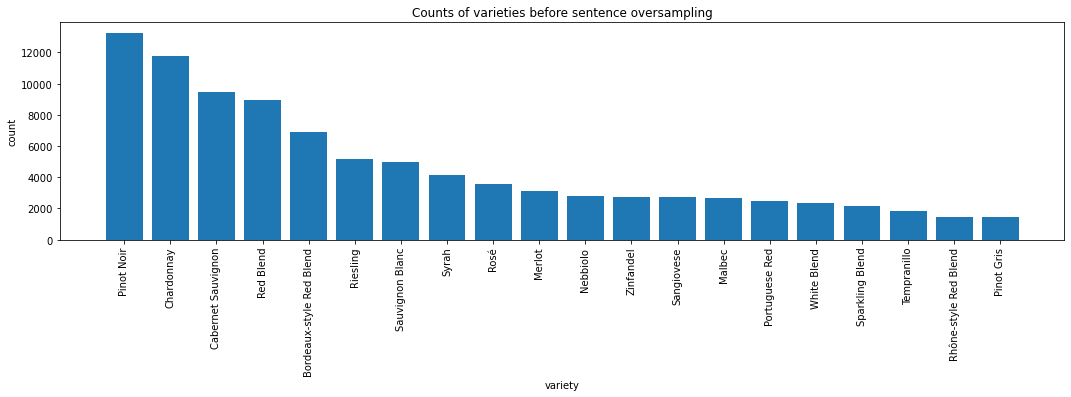

In [21]:
fig = plt.figure(figsize=(18, 4))
plt.bar(top_varieties_count[:top].index, top_varieties_count[:top].values)
plt.xticks(rotation=90)
plt.xlabel('variety')
plt.ylabel('count')
plt.title('Counts of varieties before sentence oversampling')
plt.show()

In [22]:
print('after sentence oversampling, highest class ratio is {}'.format(\
                                                    balanced_variety.iloc[0] / balanced_variety.iloc[-1]))

after sentence oversampling, highest class ratio is 3.3506690229739964


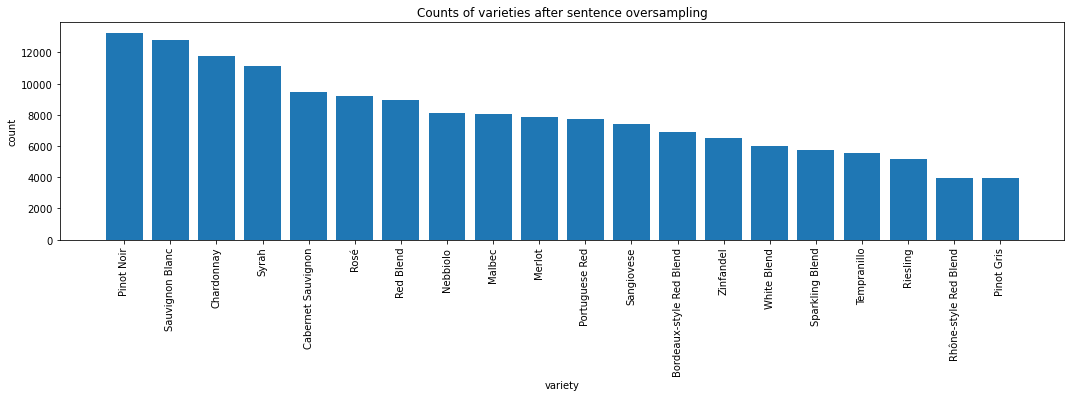

In [23]:
fig = plt.figure(figsize=(18, 4))
plt.bar(balanced_variety.index, balanced_variety.values)
plt.xticks(rotation=90)
plt.xlabel('variety')
plt.ylabel('count')
plt.title('Counts of varieties after sentence oversampling')
plt.show()

In [24]:
# importing useful libraries
import spacy
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

### Let's check for Nan values

In [25]:
nan_df = top_df.isnull().sum().to_frame()
nan_df.rename(columns={0: 'n_Nan'}, inplace=True)
nan_df['%missing'] = 100*nan_df['n_Nan'] / top_df.shape[0]
nan_df

,n_Nan,%missing
country,37,0.039398
description,0,0.000000
designation,26985,28.733735
points,0,0.000000
price,5691,6.059799
province,37,0.039398
region_1,13466,14.338650
region_2,50804,54.096301
taster_name,18863,20.085397
taster_twitter_handle,22626,24.092255


In [26]:
# creating a spacy pipeline and disabling tagger, parser and ner to speed up tokenizer
nlp = spacy.load('en', disable=['tagger', 'parser', 'ner']) 

### We will be evaluating six preprocessing approaches to choose the best one.

1. sentence oversampling without including 'not_vintage'
2. no oversampling without including 'not_vintage'
3. SMOTE oversampling without including 'not_vintage'
4. sentence oversampling including 'not_vintage'
5. no oversampling including 'not_vintage'
6. SMOTE oversampling without including 'not_vintage'

- Remeber, ````not_vintage```` is the combination of non-numeric categorical features of ````country, province, region1, region2, winery, and designation````

### First, let's make a corpus where each document is ````description```` plus ````not_vintage````

In [27]:
# for sentence oversampling
sent_oversample_corpus = [doc1 + ' ' + doc2 for doc1, doc2 in zip(\
                                                        balanced_df['description'], balanced_df['not_vintage'])]

# for no oversampling
no_oversample_corpus = [doc1 + ' ' + doc2 for doc1, doc2 in zip(\
                                                        top_df['description'], top_df['not_vintage'])]

### let's see how the combination of ````description```` and ````not_vintage```` is like

In [28]:
sent_oversample_corpus[-3:]

['It also has weight and a solid, powerful core of spice and baked apple flavors. France Alsace Alsace Domaine Marcel Deiss',
 'With its structure still developing, the wine needs to age. France Alsace Alsace Domaine Marcel Deiss',
 'Drink from 2015. France Alsace Alsace Domaine Marcel Deiss']

In [29]:
no_oversample_corpus[:3] 

["Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity. Italy Vulkà Bianco Sicily & Sardinia Etna Nicosia",
 "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016. Portugal Avidagos Douro Quinta dos Avidagos",
 'Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented. United States of America Oregon Willamette Valley Willamette Valley Rainstorm']

In [30]:
sent_oversample_le = LabelEncoder() # initializes a LabelEncoder object
# encodes the labels
sent_oversample_labels = sent_oversample_le.fit_transform([label for label in balanced_df['variety']])

no_oversample_le = LabelEncoder() # initializes a LabelEncoder object
# encodes the labels
no_oversample_label = no_oversample_le.fit_transform([label for label in top_df['variety']])

### Let's have a view of ````sent_oversample_corpus```` and ````no_oversample_corpus````

In [31]:
sent_oversample_corpus[-3:]

['It also has weight and a solid, powerful core of spice and baked apple flavors. France Alsace Alsace Domaine Marcel Deiss',
 'With its structure still developing, the wine needs to age. France Alsace Alsace Domaine Marcel Deiss',
 'Drink from 2015. France Alsace Alsace Domaine Marcel Deiss']

In [32]:
no_oversample_corpus[-3:]

["Notes of honeysuckle and cantaloupe sweeten this deliciously feather-light spätlese. It's intensely juicy, quenching the palate with streams of tart tangerine and grapefruit acidity, yet wraps up with a kiss of honey and peach. Germany Brauneberger Juffer-Sonnenuhr Spätlese Mosel Dr. H. Thanisch (Erben Müller-Burggraef)",
 'Citation is given as much as a decade of bottle age prior to release, which means it is pre-cellared and drinking at its peak. Baked cherry, cocoa and coconut flavors combine gracefully, with soft, secondary fruit compote highlights. United States of America Oregon Oregon Oregon Other Citation',
 'A dry style of Pinot Gris, this is crisp with some acidity. It also has weight and a solid, powerful core of spice and baked apple flavors. With its structure still developing, the wine needs to age. Drink from 2015. France Alsace Alsace Domaine Marcel Deiss']

In [33]:
# creating a dictionary to decode the encoded labels (we could also use the inverse_transform method of the 
# LabelEncoder object)
sent_oversample_map = {v: k for k, v in enumerate(sent_oversample_le.classes_)}
no_oversample_map = {v: k for k, v in enumerate(no_oversample_le.classes_)}

In [34]:
sent_oversample_labels[:3]

array([11,  7,  1])

In [35]:
sent_oversample_one_hot = OneHotEncoder(sparse=False)
sent_oversample_labels2 = sent_oversample_one_hot.fit_transform(sent_oversample_labels.reshape(-1, 1))

In [36]:
sent_oversample_labels2[:3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [37]:
sample_text = "Please! é don't Do isn't? runs honey-well ran: lo50 it did, 0.5 doiNg he 100 #fr @h... +234 " + \
                "me3 (Erben Müller-Burggraef)."
lst = []
for p in nlp(sample_text):
    if p.is_alpha:
        lst.append(p.lower_)
print(lst)

['please', 'é', 'do', 'do', 'is', 'runs', 'honey', 'well', 'ran', 'it', 'did', 'doing', 'he', 'fr', 'erben', 'müller', 'burggraef']


### we will encapsulate the above code in a list comprehension, and that will be our tokenizer function.

In [38]:
spacy_stop_words = spacy.lang.en.STOP_WORDS # getting spacy's stop-words

In [39]:
response = requests.get('https://raw.github.com/Yoast/YoastSEO.js/develop/src/config/stopwords.js')
yoast_stop_words = response.content.decode()

In [40]:
pattern = r'\[.+\]'
match = re.search(pattern, yoast_stop_words)
yoast_stop_words = set(match.group()[1:-1].replace('"', '').replace(',', '').split())
print(f'length of yoast_stop_words is {len(yoast_stop_words)}\n')
print(yoast_stop_words)

length of yoast_stop_words is 153

{"it's", 'during', 'the', 'he', 'but', 'ought', 'we', "we'd", "what's", "you've", 'has', 'through', 'these', 'above', 'more', 'were', 'or', 'as', "here's", 'about', 'very', 'hers', "he'd", "he'll", 'she', 'does', 'be', 'than', "that's", 'do', 'further', "i'll", 'why', 'have', 'those', 'myself', 'for', 'having', 'again', 'its', 'ours', "you'll", 'that', 'him', 'been', 'such', "we've", 'most', 'between', 'are', 'under', 'my', 'same', "he's", "she's", 'which', 'yours', 'own', 'below', 'her', 'and', "she'd", 'whom', 'on', 'too', 'against', 'had', 'each', 'themselves', "we're", 'this', 'when', 'out', 'itself', 'into', 'at', 'both', 'yourself', 'our', 'while', "she'll", 'other', 'doing', "they'll", "i'm", 'if', 'herself', 'your', 'then', 'being', 'could', 'how', "i've", 'am', 'here', 'to', 'theirs', 'ourselves', "they'd", 'yourselves', 'is', 'their', 'from', 'until', 'they', 'before', 'in', "let's", 'with', "you'd", "they're", "where's", 'who', 'nor', "you'

In [41]:
stop_words_lemma = {word.lemma_.lower() for word in nlp(' '.join(spacy_stop_words | yoast_stop_words))} | \
{'-pron-', '10', '12', 'aah', 'aa', 'ab', 'aaa', 'aand', '16', '2', '20', '30', '4', '40', '5', '6', '7', \
 '8', '9'}

### After tokenizer, there is a weird word '-pron-' that appears probably because spacy lemmatizers some pronouns as '-pron-'. So numbers strangely still appeared after tokenizing (and double tokenizing)...it may be due to a bug in spacy. We wil include these to our stop-words. and lemmatize our stop words since we are lemmatizing our tokens.

In [42]:
# defining tokenzer function to tokenize the lower case lemma of documents in a corpus and 
# filter out stop-words  
def tokenizer(text):
    return [word.lemma_.lower() for word in nlp(text) if word.is_alpha and word.lemma_.lower() \
                not in stop_words_lemma]

## Word2vec

### Word2vec converts each word to an n-dimensional vector by using neural network to encode the context usage of words in a sentence. It is advantageous than Tfidf because it takes context into consideration. For this notebook, we will encoding into a 300 dimensional vector with the continuous bag of words (CBOW) strategy (default) on a window size of 5 (default) which seems to be the best for our data.

In [43]:
from gensim.models import Word2Vec # importing Word2Vec

In [44]:
# defining a function to return the mean word2vec vectors of words in a review (document) as the document vector 
def get_doc_vector(model, doc):
    return np.mean([model[word] for word in doc if word in model.wv.vocab], axis=0)

### First, let's make a corpus where each document is ````description```` plus ````not_vintage````

## Step 4

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [46]:
# tokenize (lemmatize and filter stop words) corpus 
sent_oversample_corpus1 = [' '.join(tokenizer(doc)) for doc in sent_oversample_corpus] 
print(sent_oversample_corpus1[-3:])

['weight solid powerful core spice bake apple flavor france alsace alsace domaine marcel deiss', 'structure develope wine need age france alsace alsace domaine marcel deiss', 'drink france alsace alsace domaine marcel deiss']


In [47]:
sequence_tokenizer = Tokenizer()
sequence_tokenizer.fit_on_texts(sent_oversample_corpus1)

words_indices = sequence_tokenizer.word_index

print('vocab size (number of unique words + 1) is {}'.format(len(words_indices) + 1))  
# Adding 1 because of reserved 0 index

vocab size (number of unique words + 1) is 39563


In [48]:
sent_oversample_corpus2 = sequence_tokenizer.texts_to_sequences(sent_oversample_corpus1)
print(sent_oversample_corpus1[-3])
print()
print(sent_oversample_corpus2[-3])

weight solid powerful core spice bake apple flavor france alsace alsace domaine marcel deiss

[211, 209, 280, 212, 30, 133, 52, 7, 9, 99, 99, 80, 4049, 7437]


## Padding: All wine review won't have the same number of words, for this reason, we will use a sequence length equal to the number of words the review with the maximum number of words has. For review word count lesser than this, we will fill (pad) with zeros.

In [49]:
from keras.preprocessing.sequence import pad_sequences

In [50]:
sent_oversample_corpus3 = pad_sequences(sent_oversample_corpus2, padding='post')
sent_oversample_corpus3[-3]

array([ 211,  209,  280,  212,   30,  133,   52,    7,    9,   99,   99,
         80, 4049, 7437,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

## Training word2vec

In [51]:
sent_oversample_corpus4 = [tokenizer(doc) for doc in sent_oversample_corpus] # gets corpus as a list of lists
print(sent_oversample_corpus4[:2])

[['pineapple', 'rind', 'lemon', 'pith', 'orange', 'blossom', 'start', 'aroma', 'palate', 'bite', 'opulent', 'note', 'honey', 'drizzle', 'guava', 'mango', 'way', 'slightly', 'astringent', 'semidry', 'finish', 'united', 'states', 'america', 'reserve', 'late', 'harvest', 'michigan', 'lake', 'michigan', 'shore', 'julian'], ['like', 'regular', 'bottle', 'come', 'rough', 'tannic', 'rustic', 'earthy', 'herbal', 'characteristic', 'nonetheless', 'think', 'pleasantly', 'unfussy', 'country', 'wine', 'companion', 'hearty', 'winter', 'stew', 'united', 'states', 'america', 'vintner', 'reserve', 'wild', 'child', 'block', 'oregon', 'willamette', 'valley', 'willamette', 'valley', 'sweet', 'cheeks']]


In [52]:
# trains sent_oversample_corpus2 on Word2Vec. For sent_oversample_corpus2, min_count of 5 and iter (epoch) of 10 
# seems to be the best
sent_w2v_model = Word2Vec(sent_oversample_corpus4, size=300, min_count=1, iter=10)

print(sent_w2v_model) # sumarizes the word2vec

Word2Vec(vocab=39562, size=300, alpha=0.025)


In [53]:
# getting the word2vec embeddings (vectors) of the corpus as input array
#words_vectors = np.array([get_doc_vector(sent_w2v_model, doc) for doc in sent_oversample_corpus2])

In [54]:
sent_w2v_model['pineapple'].shape # confirms the dimension of our embedding

(300,)

### Let's see some Word2Vec magic to boost our confidence in our trained word2vec model

In [55]:
# picking out the odd word
sent_w2v_model.wv.doesnt_match(['cherry', 'italy', 'apple', 'pineapple', 'tangerine'])

'italy'

In [56]:
# picking out the odd word
sent_w2v_model.wv.doesnt_match(['arizona', 'france', 'michigan', 'texas', 'pennsylvania'])

'france'

In [57]:
# let's see a random province in Portugal
balanced_df[balanced_df['country'] == 'Portugal']['province'].unique()[0]

'Estremadura'

In [58]:
#provinces in Canada
balanced_df[balanced_df['country'] == 'Canada']['province'].unique()

array(['British Columbia', 'Ontario'], dtype=object)

In [59]:
# just like king - man + woman = queen, we want to prove that portugal - estremadura + ontario = canada
print(sent_w2v_model.wv.most_similar(positive=['portugal', 'ontario'], negative=['estremadura']))

[('canada', 0.5529643893241882), ('germany', 0.4322347640991211), ('emphasize', 0.4089052677154541), ('lip', 0.361308753490448), ('austria', 0.35200411081314087), ('balanced', 0.3435593843460083), ('stylish', 0.3405321538448334), ('reverberate', 0.3393785059452057), ('capture', 0.33905303478240967), ('hedgerow', 0.3382529318332672)]


### From the result above, 'Canada' is our model's best answer

In [60]:
# let's see the most similar words to 'aroma'
print(sent_w2v_model.wv.most_similar('aroma'))

[('scent', 0.7862091064453125), ('aromas', 0.7494959831237793), ('bouquet', 0.6748150587081909), ('note', 0.6163897514343262), ('nose', 0.5877629518508911), ('smell', 0.5817331075668335), ('flavors', 0.5766676068305969), ('fragrance', 0.558698832988739), ('whiff', 0.551872730255127), ('tone', 0.5374629497528076)]


In [61]:
# let's see the most similar words to 'orange'
print(sent_w2v_model.wv.most_similar('orange'))

[('tangerine', 0.6658437252044678), ('nasturtium', 0.5994797945022583), ('lemon', 0.5969231724739075), ('citrus', 0.5962605476379395), ('watermelon', 0.5245403051376343), ('nectarine', 0.5225023031234741), ('santella', 0.5199488401412964), ('grapefruit', 0.4952017664909363), ('lime', 0.4873845875263214), ('lemongrass', 0.48141592741012573)]


### Word2Vec is powerful in capturing contexual semantics of words. Our Word2Vec model is doing that just right to a large extent.

In [62]:
assert len(words_indices) == len(sent_w2v_model.wv.vocab)

## Modelling

### Defining a function that creates an embedding matrix

In [63]:
def get_embedding_matrix(model, word_index):
    vocab_size = len(word_index) + 1
    embedding_dim = model.wv.vector_size
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word in model.wv.vocab:
        ind = word_index[word]
        embedding_matrix[ind] = model[word]
        
    return embedding_matrix

In [64]:
embedding_matrix = get_embedding_matrix(sent_w2v_model, words_indices)

In [65]:
embedding_matrix.shape

(39563, 300)

### defining custom fbeta function

In [66]:
def multi_class_fbeta(ytrue , ypred, beta=1, weighted=True, raw=False, epsilon=1e-7):
    beta_squared = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred= tf.cast(ypred, tf.float32)
    
    max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)
    ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)
        
    tp = tf.reduce_sum(ytrue*ypred, axis=0)
    predicted_positive = tf.reduce_sum(ypred, axis=0)
    actual_positive = tf.reduce_sum(ytrue, axis=0)
    
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)
    
    if raw:
        return fb
    
    if weighted:
        supports = tf.reduce_sum(ytrue, axis=0)
        return tf.reduce_sum(fb*supports / tf.reduce_sum(supports))

    return tf.reduce_mean(fb)

### setting class weights

In [67]:
from sklearn.utils import class_weight

In [68]:
class_weights = class_weight.compute_class_weight('balanced', np.arange(20), sent_oversample_labels)
class_weights = {k: v for k, v in enumerate(class_weights)}

In [69]:
print(class_weights)

{0: 1.1543600867678958, 1: 0.8427364864864865, 2: 0.6791797838849656, 3: 0.9919721635392071, 4: 1.013766827533655, 5: 0.9846305661773775, 6: 2.015248674577127, 7: 0.6014466546112116, 8: 1.0321179208688906, 9: 0.8922870556673373, 10: 2.009667673716012, 11: 1.5383310849874734, 12: 0.8669925057021831, 13: 1.0740581270182992, 14: 0.6235762831028826, 15: 1.3906620209059233, 16: 0.7173256649892163, 17: 1.4377521613832853, 18: 1.3229035465694399, 19: 1.2257985257985258}


In [70]:
# importing deep learning libraries
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPool1D, GlobalAvgPool1D, Conv1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

### Defining a function to build a neural network

In [71]:
sent_oversample_corpus3.shape

(159648, 87)

In [72]:
def build_cnn_model():
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                           weights=[embedding_matrix], 
                           input_length=sent_oversample_corpus3.shape[1],
                           mask_zero=True,
                           trainable=False))
    
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))
    
    model.add(GlobalMaxPool1D())
    
    model.add(Dropout(0.2))
    
    model.add(Dense(20, activation='softmax'))

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', multi_class_fbeta])

    return model

In [73]:
model = build_cnn_model() # builds model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 87, 300)           11868900  
_________________________________________________________________
conv1d (Conv1D)              (None, 85, 128)           115328    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 83, 128)           49280     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2580      
Total params: 12,036,088
Trainable params: 167,188
Non-trainable params: 11,868,900
______________________________________

In [74]:
history = model.fit(sent_oversample_corpus3, sent_oversample_labels2,
                    epochs=20,
                    verbose=True,
                    validation_split=0.25,
                    batch_size=128,
                    class_weight=class_weights)

Epoch 1/20
936/936 [==============================] - 9s 10ms/step - loss: 0.8329 - accuracy: 0.7344 - multi_class_fbeta: 0.7326 - val_loss: 0.7832 - val_accuracy: 0.7484 - val_multi_class_fbeta: 0.7616
Epoch 2/20
936/936 [==============================] - 9s 9ms/step - loss: 0.5760 - accuracy: 0.8087 - multi_class_fbeta: 0.8091 - val_loss: 0.7247 - val_accuracy: 0.7678 - val_multi_class_fbeta: 0.7803
Epoch 3/20
936/936 [==============================] - 9s 10ms/step - loss: 0.5166 - accuracy: 0.8235 - multi_class_fbeta: 0.8242 - val_loss: 0.7620 - val_accuracy: 0.7535 - val_multi_class_fbeta: 0.7742
Epoch 4/20
936/936 [==============================] - 9s 10ms/step - loss: 0.4744 - accuracy: 0.8358 - multi_class_fbeta: 0.8364 - val_loss: 0.6861 - val_accuracy: 0.7814 - val_multi_class_fbeta: 0.7937
Epoch 5/20
936/936 [==============================] - 9s 9ms/step - loss: 0.4449 - accuracy: 0.8442 - multi_class_fbeta: 0.8453 - val_loss: 0.7388 - val_accuracy: 0.7660 - val_multi_class_f

### defining a function to plot learning curves

In [75]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    fbeta = history.history['multi_class_fbeta']
    val_fbeta = history.history['val_multi_class_fbeta']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    metrics = {'loss': (loss, val_loss), 'accuracy': (acc, val_acc), 'fbeta': (fbeta, val_fbeta)}
    
    plt.figure(figsize=(18, 5))
    
    for i, metric in zip(range(1, 4), list(metrics.keys())):
        plt.subplot(1, 3, i)
        plt.plot(epochs, metrics[metric][0], 'b', label='Training ' + metric)
        plt.plot(epochs, metrics[metric][1], 'r', label='Validation ' + metric)
        plt.title('Training and validation ' + metric)
        plt.legend()

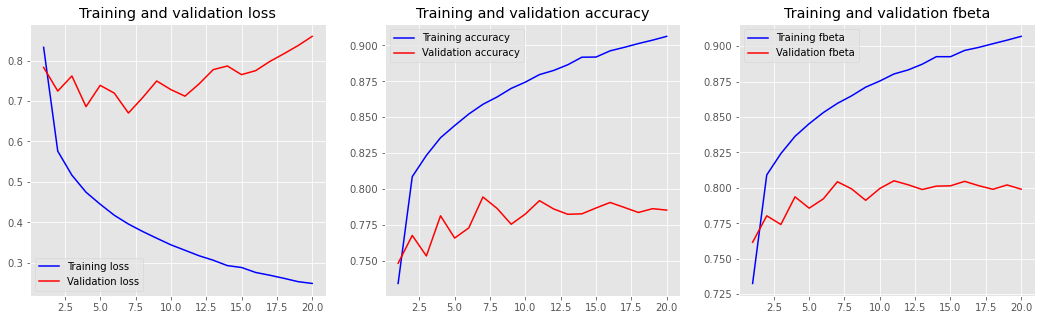

In [76]:
plot_history(history)

### cross validation score (important score to report that is less affected by overfitting)

In [77]:
model2 = KerasClassifier(build_fn=build_cnn_model) # build model
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min',\
    restore_best_weights=True)

In [78]:
# creating a RepeatedStratifiedKFold object. Since we plan using 25% as our test-size, we will use 4 fold cv.
# to have a level plain ground for comparing different models, we will be using random state of 1 through out.
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)

### setting n_jobs greater than 1 always throw error. After looking up keras and sklearn's related issues in their github repo, it seems it is a bug that needs to be fixed. We have no option but to use njobs=1, although, it will run for long.

In [79]:
# getting cross validation scores
score = cross_val_score(model2, sent_oversample_corpus3, sent_oversample_labels, scoring='f1_weighted', cv=cv,\
                        n_jobs=1, verbose=1, fit_params={\
                        'epochs': 20, 'batch_size': 128, 'class_weight': class_weights, 'verbose': 0, \
                                                         'callbacks': [early_stop]})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 23.3min finished


In [80]:
print(score)
np.mean(score) # reporting the mean score

[0.84971502 0.85129847 0.8525017  0.85044475 0.85335614 0.85502505
 0.85022352 0.84982055 0.84995484 0.85566338 0.85080444 0.85052362]


0.851610956258059

## Reporting other useful results.

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [82]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(sent_oversample_corpus3, sent_oversample_labels2, \
                                        test_size=0.25, random_state=1, stratify=sent_oversample_labels2)

### We don't want to use either model 1 or model 2 to predict the test set because both must have somehow be trained on the test set. So we need to rebuild another model that won't see the test set.

In [83]:
val_loss = history.history['val_loss']
best_epoch = np.argmin(val_loss) + 1
best_epoch

7

In [84]:
model3 = build_cnn_model() # builds model

In [85]:
model3.fit(X_train, y_train,
                    epochs=best_epoch, # using the best epoch from model1
                    verbose=True,
                    batch_size=128,
                    class_weight=class_weights)

Epoch 1/7
936/936 [==============================] - 7s 8ms/step - loss: 0.8728 - accuracy: 0.7206 - multi_class_fbeta: 0.7210
Epoch 2/7
936/936 [==============================] - 7s 8ms/step - loss: 0.6211 - accuracy: 0.7939 - multi_class_fbeta: 0.7953
Epoch 3/7
936/936 [==============================] - 8s 8ms/step - loss: 0.5570 - accuracy: 0.8118 - multi_class_fbeta: 0.8129
Epoch 4/7
936/936 [==============================] - 8s 8ms/step - loss: 0.5169 - accuracy: 0.8235 - multi_class_fbeta: 0.8248
Epoch 5/7
936/936 [==============================] - 8s 8ms/step - loss: 0.4834 - accuracy: 0.8329 - multi_class_fbeta: 0.8341
Epoch 6/7
936/936 [==============================] - 7s 8ms/step - loss: 0.4549 - accuracy: 0.8405 - multi_class_fbeta: 0.8414
Epoch 7/7
936/936 [==============================] - 7s 8ms/step - loss: 0.4343 - accuracy: 0.8474 - multi_class_fbeta: 0.8483


In [86]:
loss, accuracy, fbeta = model3.evaluate(X_train, y_train, batch_size=128, verbose=False)
print('Training Accuracy: {:.4f}\nTraining Fbeta: {:.4f}'.format(accuracy, fbeta))
print()
loss, accuracy, fbeta = model3.evaluate(X_test, y_test, batch_size=128, verbose=False)
print('Testing Accuracy: {:.4f}\nTesting Fbeta: {:.4f}'.format(accuracy, fbeta))


Training Accuracy: 0.8769
Training Fbeta: 0.8780

Testing Accuracy: 0.8342
Testing Fbeta: 0.8353


In [87]:
y_pred_train = model3.predict(X_train)
y_pred_test = model3.predict(X_test)

In [88]:
print('Training AUC: {:.4f}'.format(\
    roc_auc_score(y_train, y_pred_train, average='weighted', multi_class='ovr')))
      
print('Testing AUC: {:.4f}'.format(\
    roc_auc_score(y_test, y_pred_test, average='weighted', multi_class='ovr')))

Training AUC: 0.9950
Testing AUC: 0.9906


In [89]:
multi_class_fbeta(y_train, y_pred_train, raw=True)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.92104745, 0.87125313, 0.93643177, 0.87066853, 0.6729136 ,
       0.9911387 , 0.8678187 , 0.9524494 , 0.96940416, 0.8943138 ,
       0.81513476, 0.9393498 , 0.86350095, 0.920891  , 0.8617314 ,
       0.96824837, 0.70033157, 0.9005363 , 0.8238794 , 0.803033  ],
      dtype=float32)>

In [90]:
multi_class_fbeta(y_test, y_pred_test, raw=True)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.8889539 , 0.82175344, 0.9025915 , 0.8289578 , 0.5736211 ,
       0.9887864 , 0.7759103 , 0.9295168 , 0.9698518 , 0.85467815,
       0.75078017, 0.8903133 , 0.8165443 , 0.9070282 , 0.8175298 ,
       0.94399434, 0.62461215, 0.86287373, 0.76055497, 0.7485852 ],
      dtype=float32)>